### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [15, 8]
from IPython import display
from ipywidgets import interact, widgets
from scipy import optimize

## Read Data for Cases, Deaths and Recoveries
ConfirmedCases_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
Deaths_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
Recoveries_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [2]:
ConfirmedCases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,43,47,48,50,50,50,53,59
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,274,293,331,360,420,461,502,511,581,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,108,110,110,117,130,138,150,150,160,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,29,36,50,50,83,93,99,117,129,149


In [3]:
### Melt the dateframe into the right shape and set index
def cleandata(df_raw, drop_country=None):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
    df_cleaned=df_cleaned.set_index(['Country/Region','Province/State','Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned 

### Get Countrywise Data
def countrydata(df_cleaned,oldname,newname):
    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()
    df_country=df_country.set_index(['Country/Region','Date'])
    df_country.index=df_country.index.set_levels([df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)
    df_country=df_country.rename(columns={oldname:newname})
    return df_country

### Get DailyData from Cumulative sum
def dailydata(dfcountry,oldname,newname):
    dfcountrydaily=dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily=dfcountrydaily.rename(columns={oldname:newname})
    return dfcountrydaily

In [4]:
# Clean all datasets
ConfirmedCases=cleandata(ConfirmedCases_raw, ['China', 'Mainland China'])
Deaths=cleandata(Deaths_raw, ['China', 'Mainland China'])
Recoveries=cleandata(Recoveries_raw, ['China', 'Mainland China'])

In [5]:
ConfirmedCases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Thailand,NaN,1/22/20,15.0000,101.0000,2
Japan,NaN,1/22/20,36.0000,138.0000,2
Singapore,NaN,1/22/20,1.2833,103.8333,0
Nepal,NaN,1/22/20,28.1667,84.2500,0
Malaysia,NaN,1/22/20,2.5000,112.5000,0


In [6]:
# Get countrywise data
ConfirmedCasesCountry=countrydata(ConfirmedCases,'Cases','Total Confirmed Cases')
DeathsCountry=countrydata(Deaths,'Cases','Total Deaths')
RecoveriesCountry=countrydata(Recoveries,'Cases','Total Recoveries')

In [7]:
# Get Daily Data
NewCasesCountry=dailydata(ConfirmedCasesCountry,'Total Confirmed Cases','Daily New Cases')
NewDeathsCountry=dailydata(DeathsCountry,'Total Deaths','Daily New Deaths')
NewRecoveriesCountry=dailydata(RecoveriesCountry,'Total Recoveries','Daily New Recoveries')

In [8]:
CountryConsolidated=pd.merge(ConfirmedCasesCountry,NewCasesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewDeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,DeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,RecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewRecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated['Active Cases']=CountryConsolidated['Total Confirmed Cases']-CountryConsolidated['Total Deaths']-CountryConsolidated['Total Recoveries']
CountryConsolidated['Share of Recoveries - Closed Cases']=np.round(CountryConsolidated['Total Recoveries']/(CountryConsolidated['Total Recoveries']+CountryConsolidated['Total Deaths']),2)
CountryConsolidated['Death to Cases Ratio']=np.round(CountryConsolidated['Total Deaths']/CountryConsolidated['Total Confirmed Cases'],3)

In [9]:
CountryConsolidated.reset_index().groupby('Date').sum()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-01-22,7,0.0,0.0,0,0,0.0,7,0.00,0.000
2020-01-23,10,3.0,0.0,0,0,0.0,10,0.00,0.000
2020-01-24,21,11.0,0.0,0,0,0.0,21,0.00,0.000
2020-01-25,28,7.0,0.0,0,0,0.0,28,0.00,0.000
2020-01-26,43,15.0,0.0,0,3,3.0,40,2.00,0.000
2020-01-27,50,7.0,0.0,0,3,0.0,47,2.00,0.000
2020-01-28,69,19.0,0.0,0,6,3.0,63,2.00,0.000
2020-01-29,79,10.0,0.0,0,6,0.0,73,2.00,0.000
2020-01-30,93,14.0,0.0,0,8,2.0,85,3.00,0.000


In [10]:
GlobalTotals=CountryConsolidated.reset_index().groupby('Date').sum()
GlobalTotals['Share of Recoveries - Closed Cases']=np.round(GlobalTotals['Total Recoveries']/(GlobalTotals['Total Recoveries']+GlobalTotals['Total Deaths']),2)
GlobalTotals['Death to Cases Ratio']=np.round(GlobalTotals['Total Deaths']/GlobalTotals['Total Confirmed Cases'],3)
GlobalTotals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-03-10,38411,5710.0,286.0,1151,4230,540.0,33030,0.79,0.030
2020-03-11,46047,7636.0,335.0,1486,5370,1140.0,39191,0.78,0.032


In [11]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 46047.000
Daily New Cases                        7636.000
Daily New Deaths                        335.000
Total Deaths                           1486.000
Total Recoveries                       5370.000
Daily New Recoveries                   1140.000
Active Cases                          39191.000
Share of Recoveries - Closed Cases        0.780
Death to Cases Ratio                      0.032
Name: 2020-03-11 00:00:00, dtype: float64

In [12]:
total_death = GlobalTotals.iloc[-1]['Total Deaths']
total_recoveries = GlobalTotals.iloc[-1]['Total Recoveries']
total_closed = total_death + total_recoveries

In [13]:
total_death / total_closed

0.21674445740956827

In [14]:
plt.style.use('seaborn-dark')

## Sigmoid Model Fit
Let's try to fit a model to the data

In [15]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLoc.head()
TotalCasesLoc['Location']=np.where(TotalCasesLoc['Country/Region']=='Mainland China','Mainland China','Outside China')
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Location','Date'])['Total Confirmed Cases'].sum().reset_index()
TotalCasesLocaggregated['Projected Infections'] = TotalCasesLocaggregated['Total Confirmed Cases'] * 10
TotalCasesLocaggregated.tail(5)

,Location,Date,Total Confirmed Cases,Projected Infections
45,Outside China,2020-03-07,25051,250510
46,Outside China,2020-03-08,28972,289720
47,Outside China,2020-03-09,32701,327010
48,Outside China,2020-03-10,38411,384110
49,Outside China,2020-03-11,46047,460470


In [16]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 46047.000
Daily New Cases                        7636.000
Daily New Deaths                        335.000
Total Deaths                           1486.000
Total Recoveries                       5370.000
Daily New Recoveries                   1140.000
Active Cases                          39191.000
Share of Recoveries - Closed Cases        0.780
Death to Cases Ratio                      0.032
Name: 2020-03-11 00:00:00, dtype: float64

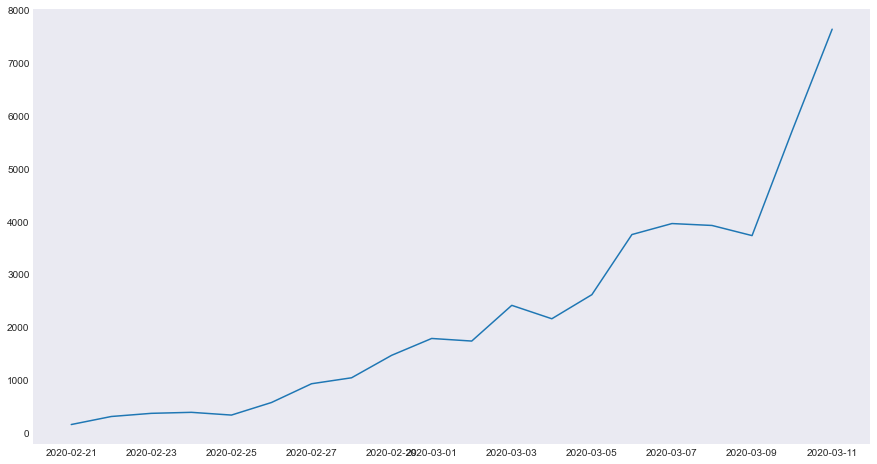

In [17]:
plt.plot(GlobalTotals.iloc[-20:]['Daily New Cases'])

In [18]:
var_range = np.arange(0.0,0.6,0.1)
var_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [19]:
df = TotalCasesLocaggregated.set_index('Date')
y_data = df['Total Confirmed Cases'].values
daily_new_cases = GlobalTotals.iloc[-1]['Daily New Cases']

def logistic(x, a, b, c):
     y = c / (1 + np.exp(-b*(x-a)))
     return y

var_params = []
var_dict = {}
for variance in var_range:
    y = y_data.copy()
    #y[-1] = y[-1] * (1 + variance)
    y = np.append(y, y[-1] + daily_new_cases * (1 + variance))
    x = np.array(range(len(y)))
    params, params_covariance = optimize.curve_fit(logistic, x, y, p0=[50, 0.1, 1000000])
    var_dict[variance] = params
    var_params.append(params)
    print(params)

[5.47162030e+01 1.95307584e-01 1.86351972e+05]
[5.57598580e+01 1.92268323e-01 2.15907819e+05]
[5.69930496e+01 1.89261481e-01 2.57752159e+05]
[5.84995093e+01 1.86287966e-01 3.21533666e+05]
[6.04386045e+01 1.83348736e-01 4.30572531e+05]
[6.31808500e+01 1.80444739e-01 6.59382101e+05]


(737476.0, 737507.95)

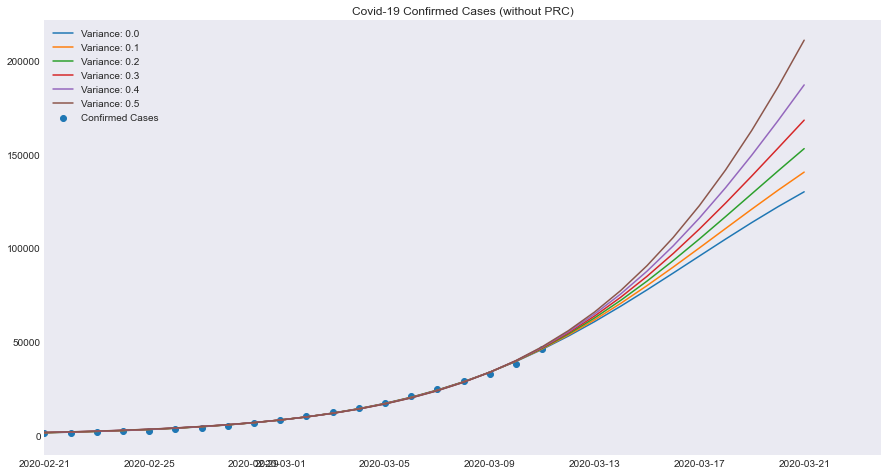

In [20]:
rg = np.array(range(60))
dr1 = pd.date_range(df.index[0], periods=60)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 3)))
plt.scatter(dr2, y_data, label='Confirmed Cases')
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')
plt.xlim(left=df.index[30])

Text(0.5, 1.0, 'Covid-19 Confirmed Cases (without PRC)')

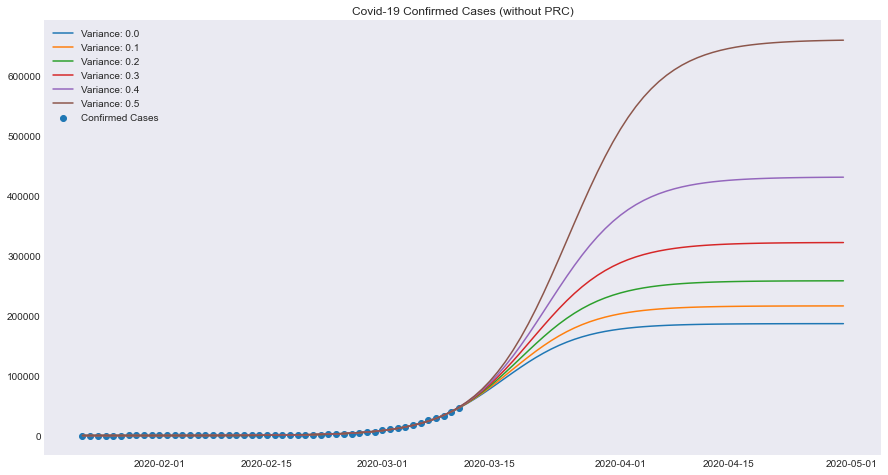

In [21]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
plt.scatter(dr2, y_data, label='Confirmed Cases')
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 2)))
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')

In [22]:
scenarios = [1, 2, 5, 10]

In [23]:
df = TotalCasesLocaggregated.set_index('Date')
x_data = np.array(range(len(df.index)))
y_data = df['Total Confirmed Cases'].values

def logistic(x, a, b, c):
     y = c / (1 + np.exp(-b*(x-a)))
     return y

var_params = []
var_dict = {}
for scen in scenarios:
    y = y_data.copy() * scen
    params, params_covariance = optimize.curve_fit(logistic, x_data, y, p0=[100, 0.1, 400000])
    var_dict[scen] = params
    var_params.append(params)
    print(params)

[5.24086953e+01 2.04138400e-01 1.35725178e+05]
[5.24086883e+01 2.04138438e-01 2.71450113e+05]
[5.24086921e+01 2.04138416e-01 6.78625609e+05]
[5.24087031e+01 2.04138363e-01 1.35725319e+06]


C:\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

overflow encountered in exp



Text(0.5, 1.0, 'Covid-19 Model Infections (without PRC)')

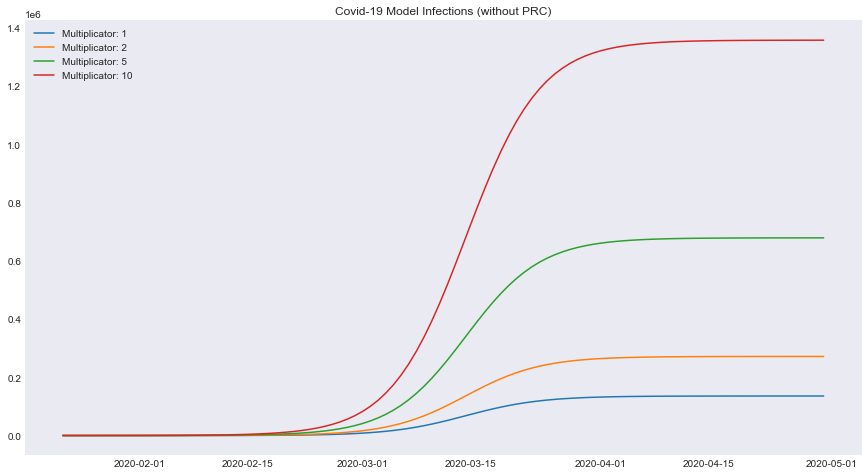

In [24]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
#plt.scatter(dr2, y_data, label='Confirmed Cases')
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Multiplicator: {}'.format(round(variance, 2)))
plt.legend(loc='best')
plt.title('Covid-19 Model Infections (without PRC)')

Text(0.5, 1.0, 'Covid-19 Model Infections (without PRC)')

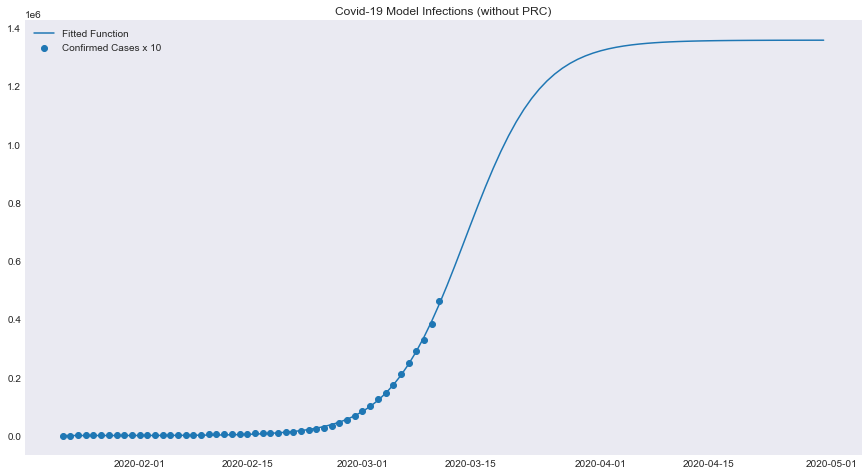

In [25]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
plt.scatter(dr2, y_data*10, label='Confirmed Cases x 10')
fit_params = var_dict[10]
plt.plot(dr1, logistic(rg, *fit_params), label='Fitted Function')
plt.legend(loc='best')
plt.title('Covid-19 Model Infections (without PRC)')